New things

1. Added a function wrapper to generalize keeping the angles between -90 and 90
2. Used SNR with 3 sigma cutoff using debiased Pfrac
3. Added code for making S maps with different delta
4. Made the fits more clearer for log p vs log S and log p vs log I
5. Added code for fitting decorrelated P vs S and I (reference Laura M. Fissel 2016 page 11)

Importing the needed packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import aplpy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 18})



Writing the funtions needed

generate_RA_DEC_mesh generates RA and DEC mesh for the DATA which will be used for calculating the distances between different points.

Calc_l find the distance between two points on the space returns the value in arcsecond


In [2]:
def generate_RA_DEC_mesh(hdr):
    """generate_RA_DEC_mesh

    Generates the RA and DEC grid for the intensity map

    """
    if 'CDELT1' in hdr.header:
        RA_delt = hdr.header['CDELT1']
        DEC_delt = hdr.header['CDELT2']

    if 'CD1_1' in hdr.header:
        RA_delt = hdr.header['CD1_1']
        DEC_delt = hdr.header['CD2_2']

    RA_ref = (hdr.header['CRPIX1'])
    DEC_ref = (hdr.header['CRPIX2'])
    RA_ref_value = hdr.header['CRVAL1']
    DEC_ref_value = hdr.header['CRVAL2']
    RA_axis_len = hdr.header['NAXIS1']
    DEC_axis_len = hdr.header['NAXIS2']

    RA_axis = np.arange(1,RA_axis_len+1)
    DEC_axis = np.arange(1,DEC_axis_len+1)
    DEC_axis_modified = np.arange(1,RA_axis_len+1)
    
    DEC_array = (DEC_axis - DEC_axis_len/2)*DEC_delt + DEC_ref_value
    DEC_array_modified = (DEC_axis_modified - RA_axis_len/2)*DEC_delt + DEC_ref_value
    RA_array = RA_ref_value-(RA_axis - RA_axis_len/2)*(RA_delt*(-1)/np.cos(DEC_array_modified*0.01745))

    # #making a meshgrid from the arrays
    DEC_grid,RA_grid = np.meshgrid(DEC_array,RA_array , sparse=False, indexing='ij')
    return DEC_grid,RA_grid

def Calc_l(ra1,dec1,ra2,dec2):

    c1 = SkyCoord(ra1,dec1,unit = 'deg')
    c2 = SkyCoord(ra2,dec2,unit = 'deg')
    sep = c1.separation(c2)
    return sep.arcminute
    
def wrapper(Angle_grid):
    while ((np.nanmax(Angle_grid)>90) or (np.nanmin(Angle_grid)<-90)):
        Angle_selector =Angle_grid>90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] - 180
        Angle_selector = Angle_grid<-90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] + 180
    return Angle_grid

Importing the FITs file and some testing the data

In [3]:
# ########## importing and testing the file
# FITS1 = '../FITS_file/OMC_BandE.fits'
# hdul = fits.open(FITS1)
# # print(hdul.info())
# MapStokesI = hdul[0]
# MapStokesQ = hdul[2]
# MapStokesU = hdul[4]
# MapDebPol = hdul[8]
# MapPolAngle = hdul[11]
# MapPolFlux = hdul[13]
# MapPolFluxError = hdul[14]


# MapPolSNR = MapPolFlux.copy()
# BlankedMapPol = MapDebPol.copy()
# BlankedMapPolAngle = MapPolAngle.copy()
# BlankedMapStokesI = MapStokesI.copy()
# BlankedMapStokesQ = MapStokesQ.copy()
# BlankedMapStokesU = MapStokesU.copy()

# ######## taking points only with singal to noise ratio more than 2
# MapPolSNR.data[:] = np.nan
# MapPolSNR.data = MapPolFlux.data/MapPolFluxError.data
# Selector = (MapPolSNR.data < 2)

# BlankedMapPol.data[Selector] = np.nan
# BlankedMapPolAngle.data[Selector] = np.nan
# BlankedMapStokesI.data[Selector] = np.nan
# BlankedMapStokesQ.data[Selector] = np.nan
# BlankedMapStokesU.data[Selector] = np.nan

# ############## generating the RA and DEC mesh
# DEC_grid,RA_grid = generate_RA_DEC_mesh(hdul[0])
# seperation = MapPolAngle.copy()

New SNR with 3 sigma cutoff using debiased Pfrac

In [4]:
########## importing and testing the file
FITS1 = '../FITS_file/CygX_E_OTFMAP.fits'
hdul = fits.open(FITS1)
print(hdul.info())
MapStokesI = hdul[0]
MapStokesQ = hdul[2]
MapStokesU = hdul[4]
MapDebPol = hdul[8]
MapDebPolError = hdul[9]
MapPolAngle = hdul[11]
MapPolFlux = hdul[13]
MapPolFluxError = hdul[14]


MapPolSNR = MapDebPol.copy()
BlankedMapPol = MapDebPol.copy()
BlankedMapPolAngle = MapPolAngle.copy()
BlankedMapStokesI = MapStokesI.copy()
BlankedMapStokesQ = MapStokesQ.copy()
BlankedMapStokesU = MapStokesU.copy()

######## taking points only with singal to noise ratio more than 2
MapPolSNR.data[:] = np.nan
MapPolSNR.data = MapDebPol.data/MapDebPolError.data
Selector = (MapPolSNR.data < 3)

BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan

############## generating the RA and DEC mesh
DEC_grid,RA_grid = generate_RA_DEC_mesh(hdul[0])
seperation = MapPolAngle.copy()

Filename: ../FITS_file/CygX_E_OTFMAP.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  STOKES I      1 PrimaryHDU    1095   (110, 93)   float64   
  1  ERROR I       1 ImageHDU        19   (110, 93)   float64   
  2  STOKES Q      1 ImageHDU        19   (110, 93)   float64   
  3  ERROR Q       1 ImageHDU        19   (110, 93)   float64   
  4  STOKES U      1 ImageHDU        19   (110, 93)   float64   
  5  ERROR U       1 ImageHDU        19   (110, 93)   float64   
  6  IMAGE MASK    1 ImageHDU        35   (110, 93)   float64   
  7  PERCENT POL    1 ImageHDU        19   (110, 93)   float64   
  8  DEBIASED PERCENT POL    1 ImageHDU        19   (110, 93)   float64   
  9  ERROR PERCENT POL    1 ImageHDU        19   (110, 93)   float64   
 10  POL ANGLE     1 ImageHDU        19   (110, 93)   float64   
 11  ROTATED POL ANGLE    1 ImageHDU        19   (110, 93)   float64   
 12  ERROR POL ANGLE    1 ImageHDU        19   (110, 93)   float64   
 13  POL FLUX      1 

Finding the value of angle dispersion function at the value 50,50 (pixel value)

1st step: selecting points that lie in the annular ring

2nd step: use this grid to select the polarization angles that lie in the annular ring

3rd step: find the difference between the polarization angle at (50,50) and the annular ring

4th step: square the difference and find rms value which will be the angle dispersion value

In [5]:

############## Testing the algorithm at point x_index,y_index

# x_index = 50
# y_index = 50
# set_delta = 0.5
# ############## making the filter for selecting points withing the ring
# seperation.data = Calc_l(RA_grid[x_index,y_index],DEC_grid[x_index,y_index],RA_grid,DEC_grid)
# seperation_selector = (seperation.data<0.5*set_delta)
# seperation.data[seperation_selector] = np.nan
# seperation_selector = (seperation.data>1.5*set_delta)
# seperation.data[seperation_selector] = np.nan


# ############## first version
# AngleDiff = BlankedMapPolAngle.data - BlankedMapPolAngle.data[x_index,y_index]
# Angle_selector =AngleDiff>90
# AngleDiff[Angle_selector] = AngleDiff[Angle_selector] - 180
# Angle_selector = AngleDiff<-90
# AngleDiff[Angle_selector] = AngleDiff[Angle_selector] + 180
# seperation_selector = (seperation.data >0)
# S = np.nanmean(AngleDiff[seperation_selector]**2)**0.5
# print(S)


# ############ second version
# tempa = BlankedMapStokesQ.data*BlankedMapStokesU.data[x_index,y_index] - BlankedMapStokesQ.data[x_index,y_index]*BlankedMapStokesU.data
# tempb = BlankedMapStokesQ.data*BlankedMapStokesQ.data[x_index,y_index] + BlankedMapStokesU.data*BlankedMapStokesU.data[x_index,y_index]

# AngleDiff_v2 = (180/np.pi)*0.5*np.arctan(tempa/tempb)
# Angle_selector_v2 =AngleDiff_v2>90
# AngleDiff_v2[Angle_selector_v2] = AngleDiff_v2[Angle_selector_v2] - 180
# Angle_selector_v2 = AngleDiff_v2<-90
# AngleDiff_v2[Angle_selector_v2] = AngleDiff_v2[Angle_selector_v2] + 180
# S2 = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
# print(S2)

Use this one method over all the sky map with a nested for loop

In [6]:

########## Running the algorithm on each cell


set_delta = 0.5   # in arcminute
S_map = BlankedMapPolAngle.copy()
S_map_v2 = BlankedMapPolAngle.copy()
for i in range(RA_grid.shape[0]):
    for j in range(RA_grid.shape[1]):

        ##### seperation filter
        seperation.data = Calc_l(RA_grid[i,j],DEC_grid[i,j],RA_grid,DEC_grid)
        seperation_selector = (seperation.data<0.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data>1.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data >0)

        
        ##### first version
        # AngleDiff = BlankedMapPolAngle.data - BlankedMapPolAngle.data[i,j]
        # AngleDiff = wrapper(AngleDiff)
        # # Angle_selector =AngleDiff>90
        # # AngleDiff[Angle_selector] = AngleDiff[Angle_selector] - 180
        # # Angle_selector = AngleDiff<-90
        # # AngleDiff[Angle_selector] = AngleDiff[Angle_selector] + 180
        
        # # ## once more to take care of > 180 degree angle difference
        # # Angle_selector =AngleDiff>90
        # # AngleDiff[Angle_selector] = AngleDiff[Angle_selector] - 180
        # # Angle_selector = AngleDiff<-90
        # # AngleDiff[Angle_selector] = AngleDiff[Angle_selector] + 180

        # S = np.nanmean(AngleDiff[seperation_selector]**2)**0.5
        # S_map.data[i,j] = S

        
        # ##### second version
        tempa = BlankedMapStokesQ.data*BlankedMapStokesU.data[i,j] - BlankedMapStokesQ.data[i,j]*BlankedMapStokesU.data
        tempb = BlankedMapStokesQ.data*BlankedMapStokesQ.data[i,j] + BlankedMapStokesU.data*BlankedMapStokesU.data[i,j]
        AngleDiff_v2 = 0.5 * (180/np.pi)*np.arctan2(tempa,tempb)
        #Angle_selector_v2 =AngleDiff_v2>90
        #AngleDiff_v2[Angle_selector_v2] = AngleDiff_v2[Angle_selector_v2] - 180
        #Angle_selector_v2 = AngleDiff_v2<-90
        #AngleDiff_v2[Angle_selector_v2] = AngleDiff_v2[Angle_selector_v2] + 180
        S_v2 = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
        S_map_v2.data[i,j] = S_v2



/tmp/ipykernel_60039/2555387020.py:45: RuntimeWarning: Mean of empty slice
  S_v2 = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5


Plots for testing the S maps 

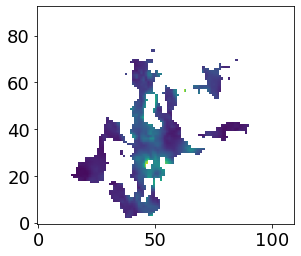

In [7]:
plt.figure()
plt.imshow(S_map_v2.data,origin='lower')
plt.show()

# plt.figure()
# ax3 = plt.subplot(131)
# ax3.imshow(MapPolAngle.data,origin='lower')
# ax1 = plt.subplot(132)
# ax1.imshow(S_map.data,origin='lower')
# ax2 = plt.subplot(133)
# ax2.imshow(S_map_v2.data,origin='lower')
# ax3.set_title('Polarization Angle')
# ax1.set_title('ADF v1')
# ax2.set_title('ADF v2')
# plt.show()

# adf_v1 = S_map.data.flatten()
# adf_v2 = S_map_v2.data.flatten()

# plt.figure()
# ax1 = plt.subplot(121)
# ax1.plot(adf_v1,adf_v2)
# ax2 = plt.subplot(122)
# ax2.plot(adf_v1-adf_v2)
# ax1.set_title('ADFv1 vs ADFv2')
# ax2.set_title('ADFv1-ADFv2 vs ADFv1')
# plt.tight_layout()
# plt.show()

# plt.figure()
# ax1 = plt.subplot(131)
# ax1.imshow(S_map.data,origin='lower',vmin=0,vmax=30)
# ax2 = plt.subplot(132)
# ax2.imshow(S_map_v2.data,origin='lower',vmin=0,vmax=30)
# ax3 = plt.subplot(133)
# ax3.imshow(S_map.data-S_map_v2.data,origin='lower')
# ax1.set_title('S map v1')
# ax2.set_title('S map v2')
# ax3.set_title('S map v1 - S map v2')
# plt.show()


Making S maps with different deltas. The delta array is in arcminute. Saves the images and plots a histogram of S maps

In [8]:
# delta_array = [0.1,0.3,0.5,0.7,0.9,1.1]

# a = []
# for i in range(len(delta_array)):

#     set_delta = delta_array[i]   # in arcminute
#     print(set_delta)
#     print(set_delta*60)
#     # S_map = BlankedMapPolAngle.copy()
#     S_map_v2 = BlankedMapPolAngle.copy()
#     for i in range(RA_grid.shape[0]):
#         for j in range(RA_grid.shape[1]):

#             ##### seperation filter
#             seperation.data = Calc_l(RA_grid[i,j],DEC_grid[i,j],RA_grid,DEC_grid)
#             seperation_selector = (seperation.data<0.5*set_delta)
#             seperation.data[seperation_selector] = np.nan
#             seperation_selector = (seperation.data>1.5*set_delta)
#             seperation.data[seperation_selector] = np.nan
#             seperation_selector = (seperation.data >0)

#             ###### second version
#             tempa = BlankedMapStokesQ.data*BlankedMapStokesU.data[i,j] - BlankedMapStokesQ.data[i,j]*BlankedMapStokesU.data
#             tempb = BlankedMapStokesQ.data*BlankedMapStokesQ.data[i,j] + BlankedMapStokesU.data*BlankedMapStokesU.data[i,j]
#             AngleDiff_v2 = 0.5*(180/np.pi)*np.arctan2(tempa,tempb)
#             #Angle_selector_v2 =AngleDiff_v2>90
#             #AngleDiff_v2[Angle_selector_v2] = AngleDiff_v2[Angle_selector_v2] - 180
#             #Angle_selector_v2 = AngleDiff_v2<-90
#             #AngleDiff_v2[Angle_selector_v2] = AngleDiff_v2[Angle_selector_v2] + 180
#             S_v2 = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
#             S_map_v2.data[i,j] = S_v2
#     plt.imshow(S_map_v2.data,origin='lower',vmin=0,vmax=30)
#     plt.savefig(str(set_delta*60)+'_adf.png',facecolor='w',bbox_inches="tight",pad_inches=0.05, transparent=True )
#     a.append(S_map_v2.data)


# bins_array = np.arange(0,90,1)
# plt.hist(a[0].flatten(), bins_array ,color='r',histtype='step', label='delta : {delta:.0f} arcsec; mean = {mean:.2f}'.format(delta = delta_array[0]*60,mean = np.nanmean(a[0])))
# plt.hist(a[1].flatten(), bins_array ,color='b',histtype='step', label='delta : {delta:.0f} arcsec; mean = {mean:.2f}'.format(delta = delta_array[1]*60,mean = np.nanmean(a[1])))
# plt.hist(a[2].flatten(), bins_array ,color='g',histtype='step', label='delta : {delta:.0f} arcsec; mean = {mean:.2f}'.format(delta = delta_array[2]*60,mean = np.nanmean(a[2])))
# plt.hist(a[3].flatten(), bins_array ,color='yellow',histtype='step', label='delta : {delta:.0f} arcsec; mean = {mean:.2f}'.format(delta = delta_array[3]*60,mean = np.nanmean(a[3])))
# plt.hist(a[4].flatten(), bins_array ,color='aqua',histtype='step', label='delta : {delta:.0f} arcsec; mean = {mean:.2f}'.format(delta = delta_array[4]*60,mean = np.nanmean(a[4])))
# plt.hist(a[5].flatten(), bins_array ,color='m',histtype='step', label='delta : {delta:.0f} arcsec; mean = {mean:.2f}'.format(delta = delta_array[5]*60,mean = np.nanmean(a[5])))

# plt.xlabel('ADF')
# plt.tight_layout()
# plt.legend()
# plt.savefig('../delta_images/histogram_adf.png',facecolor='w', bbox_inches="tight",pad_inches=0.05, transparent=True)
# # matplotlib.image.imsave('../delta_images/histogram_adf.png', )
# plt.show()


Making 2D histogram of debiased Pfrac vs S and debiased Pfrac vs I

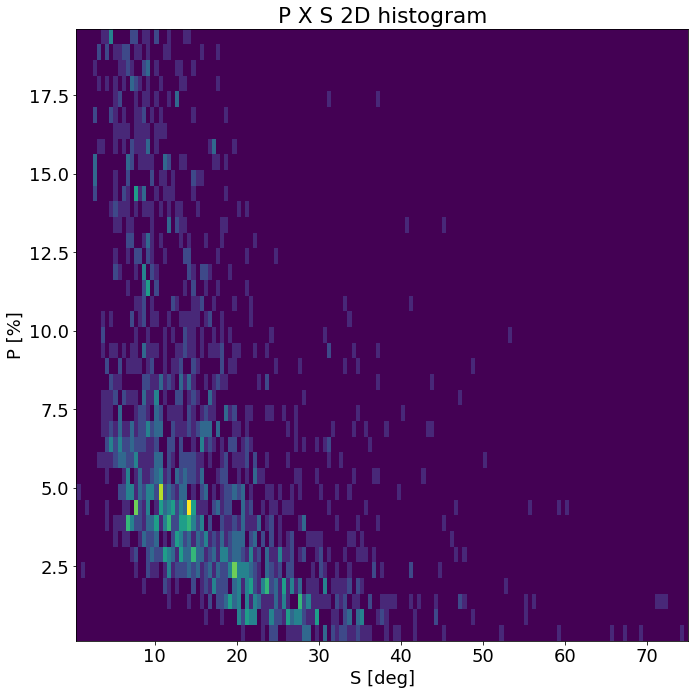

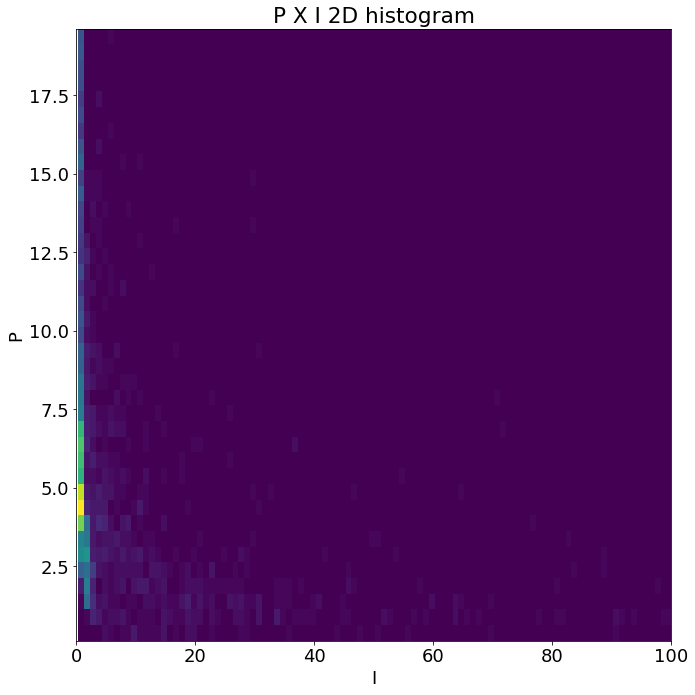

In [9]:
s_array = S_map_v2.data.flatten()
p_array = BlankedMapPol.data.flatten()
I_array = BlankedMapStokesI.data.flatten()


p_min = np.nanmin(p_array)
p_max = 20
s_min = np.nanmin(s_array)
s_max = np.nanmax(s_array)
I_min = np.nanmin(I_array)
I_max = np.nanmax(I_array)
  
s_bins = np.arange(s_min, s_max, 0.5)
p_bins = np.arange(p_min, p_max, 0.5)
I_bins = np.arange(I_min, I_max, 1)

# Creating plot
fig = plt.subplots(figsize =(10, 10))
plt.hist2d(s_array,p_array,bins =[s_bins, p_bins])
plt.title("P X S 2D histogram")
plt.ylabel('P [%]')
plt.xlabel('S [deg]')
plt.tight_layout()
plt.show()

  
fig = plt.subplots(figsize =(10, 10))
plt.hist2d(I_array,p_array,bins =[I_bins, p_bins])
plt.title("P X I 2D histogram")
plt.ylabel('P')
plt.xlabel('I')
plt.xlim([0,100])
plt.tight_layout()
plt.show()


Making 2D histogram of log debiased Pfrac vs log S and log debiased Pfrac vs log I and do a linear fit

4.1822700685402125 -0.9758613915135992


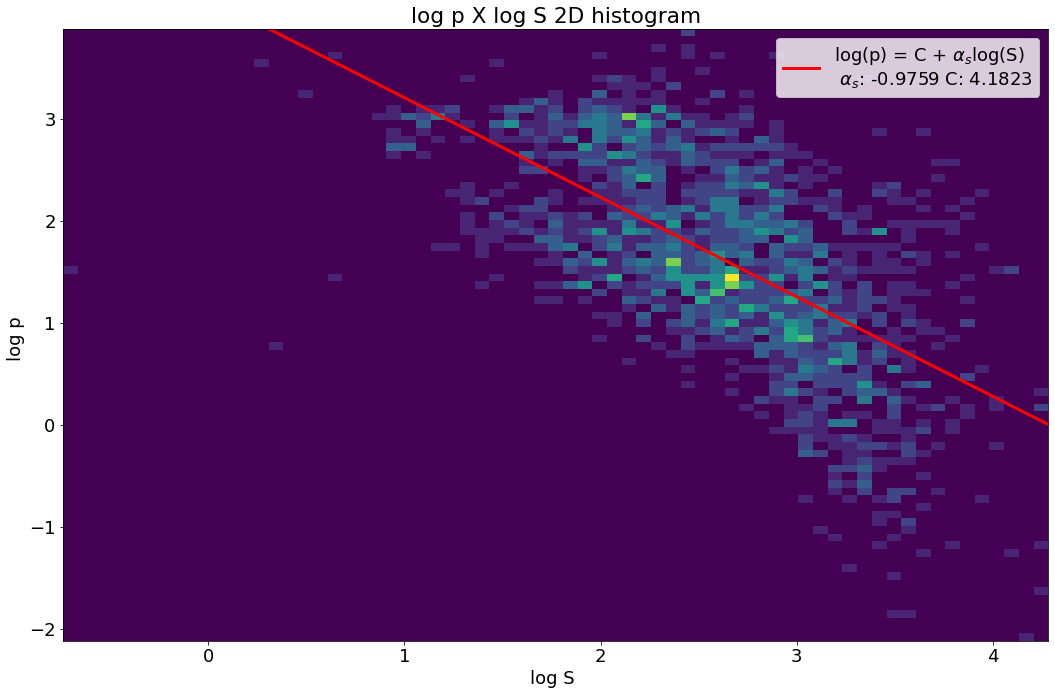

1.9236073698003229 -0.41448935627089045


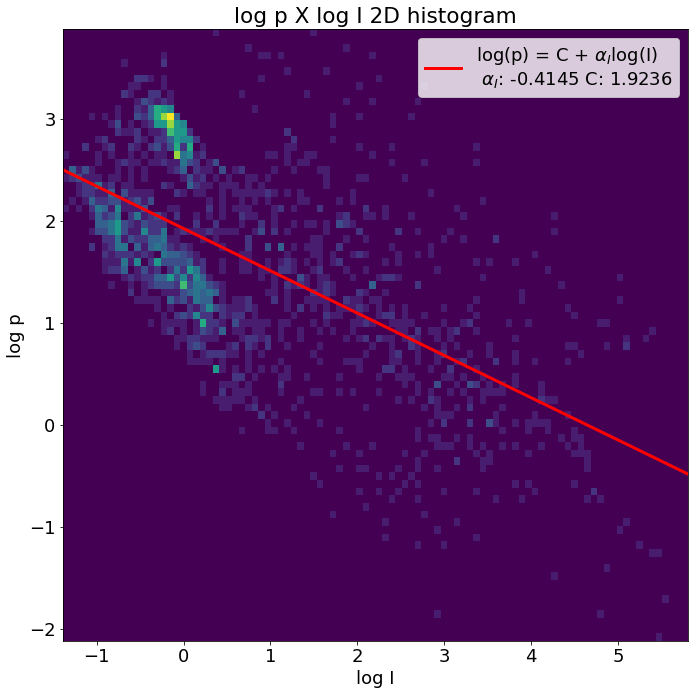

In [10]:

def lin_fit(x, a, b):
    return a + b*x

s_array = S_map_v2.data.flatten()
P_array = BlankedMapPol.data.flatten()
I_array = BlankedMapStokesI.data.flatten()

log_s = np.log(s_array)
log_p = np.log(p_array)
log_I = np.log(I_array)


p_min = np.nanmin(log_p)
p_max = np.log(50)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
  

p_bins = np.arange(p_min, p_max, 0.075)
s_bins = np.arange(s_min, s_max, 0.075)
I_bins = np.arange(I_min, I_max, 0.075)

df = pd.DataFrame({'p_array': p_array, 's_array': s_array})
df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I})
# df = df.dropna()
df_log = df_log.dropna()

PS_param, PS_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc = lin_fit(s_bins,PS_param[0],PS_param[1])
print(PS_param[0],PS_param[1])


# Plotting log p vs log s 
fig = plt.subplots(figsize =(15, 10))
plt.hist2d(log_s,log_p,bins =[s_bins, p_bins])
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_param[1],C = PS_param[0],linebreak='\n')
plt.plot(s_bins,PS_FitFunc,'r',linewidth=3,label = label_temp)
plt.title("log p X log S 2D histogram")
plt.ylabel('log p ')
plt.xlabel('log S ')
plt.legend()
plt.tight_layout()
plt.show()

PI_param, PI_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc = lin_fit(I_bins,PI_param[0],PI_param[1])
print(PI_param[0],PI_param[1])

# Plotting log p vs log I 
fig = plt.subplots(figsize =(10, 10))
plt.hist2d(log_I,log_p,bins =[I_bins, p_bins])
label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_param[1],C = PI_param[0],linebreak='\n')
plt.plot(I_bins,PI_FitFunc,'r',linewidth=3,label = label_temp)
plt.title("log p X log I 2D histogram")
plt.ylabel('log p')
plt.xlabel('log I')
plt.legend()
plt.tight_layout()
plt.show()

Making 2D histogram of log debiased Pfrac decorrelated from I vs log S and log debiased Pfrac decorrelated from S vs log I and do a linear fit

3.238866915310737 -0.5263970320784219


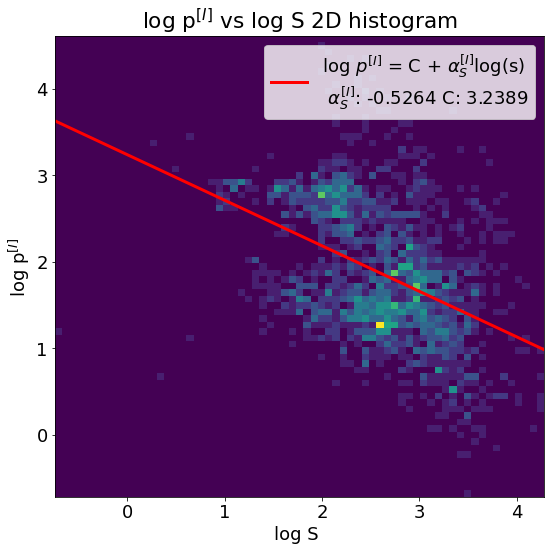

1.7528658150471017 -0.21706362548774893


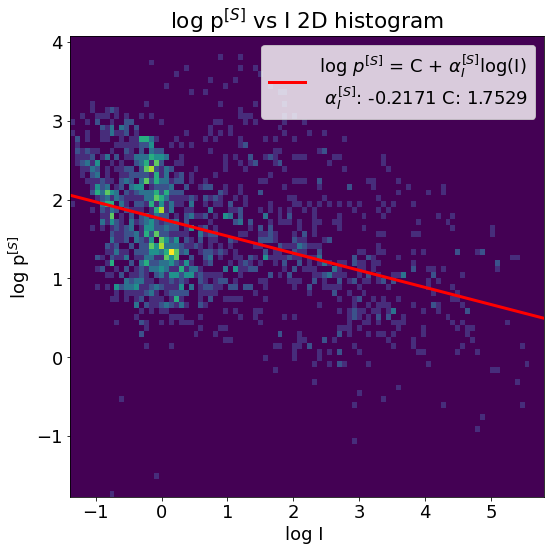

In [11]:


alpha_s = PS_param[1]
alpha_I = PI_param[1]

s_median = np.nanmedian(s_array)
I_median = np.nanmedian(I_array)

p_decol_s = p_array*((s_median/s_array)**alpha_s)

p_decol_I = p_array*((I_median/I_array)**alpha_I)

log_p_decol_s = np.log(p_decol_s)
log_p_decol_I = np.log(p_decol_I)

max_log_p_decol_s = np.nanmax(log_p_decol_s)
min_log_p_decol_s = np.nanmin(log_p_decol_s)

max_log_p_decol_I = np.nanmax(log_p_decol_I)
min_log_p_decol_I = np.nanmin(log_p_decol_I)

log_p_decol_s_bins = np.arange(min_log_p_decol_s, max_log_p_decol_s, 0.075)
log_p_decol_I_bins = np.arange(min_log_p_decol_I, max_log_p_decol_I, 0.075)

df_decol_log = pd.DataFrame({'logp_decol_s': log_p_decol_s,'logp_decol_I':log_p_decol_I})
df_decol_log = df_decol_log.dropna()

PDecI_S_param, PDecI_S_param_cov = curve_fit(lin_fit, df_log['logs'], df_decol_log['logp_decol_I'])
PDecI_S_FitFunc = lin_fit(s_bins,PDecI_S_param[0],PDecI_S_param[1])
print(PDecI_S_param[0],PDecI_S_param[1])

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
ax.hist2d(log_s,log_p_decol_I,bins =[s_bins, log_p_decol_I_bins])
label_temp = r'{logp} = C + {alpha_IS}log(s){linebreak} {alpha_IS}: {alpha_s:.4f} C: {C:.4f}'.format(logp= r'log $p^{[I]}$',alpha_IS=r'$\alpha^{[I]}_S}$',alpha_s = PDecI_S_param[1],C = PDecI_S_param[0],linebreak='\n')
ax.plot(s_bins,PDecI_S_FitFunc,'r',linewidth=3,label=label_temp)
ax.set_title(r'log p$^{[I]}$ vs log S 2D histogram')
ax.set_ylabel(r'log p$^{[I]}$')
ax.set_xlabel('log S ')
plt.legend()
plt.tight_layout()
plt.show()

PDecS_I_param, PDecS_I_param_cov = curve_fit(lin_fit, df_log['logI'], df_decol_log['logp_decol_s'])
PDecS_I_FitFunc = lin_fit(I_bins,PDecS_I_param[0],PDecS_I_param[1])
print(PDecS_I_param[0],PDecS_I_param[1])

fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
ax.hist2d(log_I,log_p_decol_s,bins =[I_bins, log_p_decol_s_bins])
label_temp = r'{logp} = C + {alpha_SI}log(I){linebreak} {alpha_SI}: {alpha_I:.4f} C: {C:.4f}'.format(logp= r'log $p^{[S]}$',alpha_SI=r'$\alpha^{[S]}_I}$',alpha_I = PDecS_I_param[1],C = PDecS_I_param[0],linebreak='\n')

# label_temp = r'{logp} = C + {alpha_SI}log(I){linebreak} {alpha_SI}: {alpha_I:.4f} C: {C:.4f}'.format(logp= r'log $p^{[S]}$',alpha_SI=r'$\alpha^{[S]}_I}$',alpha_I = PDecS_I_param[1],C = PDecI_S_param[0],linebreak='\n')
ax.plot(I_bins,PDecS_I_FitFunc,'r',linewidth=3,label=label_temp)
ax.set_title(r'log p$^{[S]}$ vs I 2D histogram')
ax.set_ylabel(r'log p$^{[S]}$')
ax.set_xlabel('log I ')
plt.legend()
plt.tight_layout()
plt.show()




In [12]:
def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

p0 = -0.5539, -0.2614, 2.
PSI_param, PSI_param_cov = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
print(PSI_param)



[ 3.59155604 -0.67433218 -0.27806576]
